## Random forest

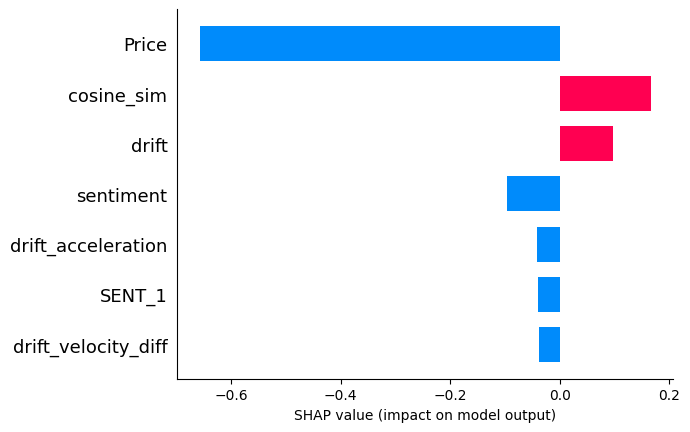

In [30]:
import shap

# Crea l'explainer SHAP per il modello RF
explainer = shap.TreeExplainer(rf)

def shap_bar_plot_for_date(date_str):
    date = pd.to_datetime(date_str)
    if date not in X_test.index:
        print(f"Data {date_str} non trovata nel test set.")
        return

    x_instance = X_test.loc[date].values.reshape(1, -1)
    shap_values = explainer.shap_values(x_instance)

    shap.bar_plot(shap_values[0], feature_names=feat_cols)

# Esempio
shap_bar_plot_for_date("2025-04-02")

In [17]:
df

Price,Price,SENT_1,SENT_2,SENT_3,cosine_sim,drift,drift_velocity,drift_velocity_diff,drift_acceleration,var_3d_1,var_3d_2,var_3d_3,sentiment,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,target
Ticker,BZ=F,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2011-06-20,111.690002,-0.042118,6.041562,0.807277,0.618741,0.381259,0.378549,-0.053754,0.027338,2.569620,7.031067,3.446203,0.600000,113.209999,114.019997,117.099998,120.160004,119.099998,110.949997
2011-06-21,110.949997,-0.042118,6.041562,0.807277,0.618741,0.381259,0.378549,-0.053754,0.027338,2.569620,7.031067,3.446203,-0.200000,111.690002,113.209999,114.019997,117.099998,120.160004,114.209999
2011-06-22,114.209999,-0.042118,6.041562,0.807277,0.618741,0.381259,0.378549,-0.053754,0.027338,2.569620,7.031067,3.446203,-0.200000,110.949997,111.690002,113.209999,114.019997,117.099998,107.260002
2011-06-23,107.260002,-0.042118,6.041562,0.807277,0.618741,0.381259,0.378549,-0.053754,0.027338,2.569620,7.031067,3.446203,0.200000,114.209999,110.949997,111.690002,113.209999,114.019997,105.120003
2011-06-24,105.120003,-0.042118,6.041562,0.807277,0.618741,0.381259,0.378549,-0.053754,0.027338,2.569620,7.031067,3.446203,-1.000000,107.260002,114.209999,110.949997,111.690002,113.209999,105.989998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16,73.230003,2.781161,5.169238,0.391155,0.666803,0.333197,0.312439,0.031267,-0.014158,2.185337,3.508264,1.991524,-0.100000,74.230003,69.360001,69.769997,66.870003,67.040001,76.449997
2025-06-17,76.449997,2.683229,5.578541,0.216865,0.847754,0.152246,0.274481,-0.037958,-0.069225,4.937330,1.135347,1.368178,0.272727,73.230003,74.230003,69.360001,69.769997,66.870003,76.699997


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
emb = (
    pd.read_csv('../Data/raw/embeddings_feature_ST.csv', parse_dates=['date'])
      .set_index('date')
)
# Rialliniamo all'indice di df
emb = emb.reindex(df.index).ffill().bfill()

sent = (
    pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date'])
      .set_index('Date')
)

# Aggiungiamo gli embedding al DataFrame principale

df['SENT_1'] = emb['embedding_2d_1_mean']
df['SENT_2'] = emb['embedding_2d_2_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_2d_1']              = emb['embedding_2d_1_var_daily']
df['var_2d_2']              = emb['embedding_2d_2_var_daily']
df['sentiment']             = sent['avg_score']

# === 3. Costruzione delle lag-feature =======================================
# Lag dei prezzi
for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)



# Target = prezzo del giorno successivo
df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# === 4. Train-test split (90/10) ============================================

feat_cols = [
    'Price','SENT_1','SENT_2',
    'cosine_sim','drift','drift_velocity','drift_velocity_diff','drift_acceleration',
    'var_2d_1','var_2d_2',
    'sentiment'
]

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train Random Forest =================================================
rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('Random Forest').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed


                          Random Forest
RMSE                             1.4577
MAE                              1.0895
MAPE (%)                         1.4488
sMAPE (%)                        1.4451
R²                               0.9581
Explained Variance               0.9581
Theil’s U                        0.0095
Directional Accuracy (%)        55.4896


#### Full Embeddings

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
# Carica embeddings giornalieri medi
emb = (
    pd.read_csv("../Data/raw/news_embeddings_only_final.csv", parse_dates=['Date'])
      .set_index('Date')
)
#emb = emb.reindex(df.index).ffill().bfill()

for col in emb.columns:
    df[col] = emb[col]
emb_cols = [col for col in emb.columns if col.startswith('emb_')]

for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# Aggiorna feat_cols
feat_cols = [
    'Price',
    'price_lag_1','price_lag_2','price_lag_3','price_lag_4','price_lag_5',
] + emb_cols

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train Random Forest =================================================
rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('Random Forest').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2493188929.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2493188929.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2493188929.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

                          Random Forest
RMSE                             1.4333
MAE                              1.0650
MAPE (%)                         1.4151
sMAPE (%)                        1.4108
R²                               0.9595
Explained Variance               0.9596
Theil’s U                        0.0093
Directional Accuracy (%)        51.9288


## XGBOOST

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
emb = (
    pd.read_csv('../Data/raw/embeddings_feature_ST.csv', parse_dates=['date'])
      .set_index('date')
)
emb = emb.reindex(df.index).ffill().bfill()
sent = (
    pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date'])
      .set_index('Date')
)

df['SENT_1'] = emb['embedding_2d_1_mean']
df['SENT_2'] = emb['embedding_2d_2_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_2d_1']              = emb['embedding_2d_1_var_daily']
df['var_2d_2']              = emb['embedding_2d_2_var_daily']
df['sentiment']             = sent['avg_score']

# === 3. Costruzione delle lag-feature =======================================
for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# === 4. Train-test split (90/10) ============================================
feat_cols = [
    'Price','SENT_1','SENT_2',
    'cosine_sim','drift','drift_velocity','drift_velocity_diff','drift_acceleration',
    'var_2d_1','var_2d_2',
    'sentiment'
]

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train XGBoost ======================================================
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"  # "gpu_hist" se hai una GPU
)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('XGBoost').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted (XGBoost)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed


                          XGBoost
RMSE                       1.9432
MAE                        1.4981
MAPE (%)                   2.0060
sMAPE (%)                  1.9905
R²                         0.9255
Explained Variance         0.9287
Theil’s U                  0.0126
Directional Accuracy (%)  54.5994


#### Full embeddings

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

SEED = 42
np.random.seed(SEED)

# === 1. Download Brent crude oil price data ==================================
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# === 2. Load & align embeddings =============================================
emb = (
    pd.read_csv("../Data/raw/news_embeddings_only_final.csv", parse_dates=['Date'])
      .set_index('Date')
)
#emb = emb.reindex(df.index).ffill().bfill()

for col in emb.columns:
    df[col] = emb[col]
emb_cols = [col for col in emb.columns if col.startswith('emb_')]

for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# Aggiorna feat_cols
feat_cols = [
    'Price',
    'price_lag_1','price_lag_2','price_lag_3','price_lag_4','price_lag_5',
] + emb_cols

X = df[feat_cols]
y = df['target']
split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === 5. Train XGBoost ======================================================
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"  # "gpu_hist" se hai una GPU
)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

# === 6. Metriche di valutazione ============================================
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) +
             np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "MAE": mean_absolute_error(y_test, preds),
    "MAPE (%)": mean_absolute_percentage_error(y_test, preds) * 100,
    "sMAPE (%)": smape(y_test.values, preds),
    "R²": r2_score(y_test, preds),
    "Explained Variance": explained_variance_score(y_test, preds),
    "Theil’s U": theils_u(y_test.values, preds),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_test.values[1:] - y_test.values[:-1]) ==
            np.sign(preds[1:] - y_test.values[:-1])
        ) * 100
    )
}

print(pd.Series(metrics).to_frame('XGBoost').round(4))

# === 7. Grafico Plotly Actual vs Predicted =================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual'
))
fig.add_trace(go.Scatter(
    x=y_test.index, y=preds, mode='lines', name='Predicted'
))
fig.update_layout(
    title='Brent Crude Oil – Actual vs Predicted (XGBoost)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2388837757.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2388837757.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2388837757.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

                          XGBoost
RMSE                       1.5058
MAE                        1.1337
MAPE (%)                   1.4963
sMAPE (%)                  1.4915
R²                         0.9552
Explained Variance         0.9554
Theil’s U                  0.0098
Directional Accuracy (%)  49.5549


## BI-GRU

https://link.springer.com/article/10.1007/s44196-024-00640-3

In [34]:
# ───────────────────── 1. LIBRERIE ─────────────────────
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import plotly.graph_objects as go

# ───────────────────── 2. SEED & DEVICE ─────────────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ───────────────────── 3. DOWNLOAD & PREPROCESSING ─────────────────────
df = (
    yf.download("CL=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close':'Price'})
      .dropna()
)

emb = (
    pd.read_csv('../Data/raw/embeddings_feature_news_embeddings_Word2Vec_HF_En.csv', parse_dates=['date'])
      .set_index('date')
      .reindex(df.index)
      .ffill().bfill()
)
sent = (
    pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date'])
      .set_index('Date')
      .reindex(df.index)
      .ffill().bfill()
)

df['SENT_1'] = emb['embedding_2d_1_mean']
df['SENT_2'] = emb['embedding_2d_2_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_2d_1']              = emb['embedding_2d_1_var_daily']
df['var_2d_2']              = emb['embedding_2d_2_var_daily']
df['sentiment']             = sent['avg_score']

for lag in range(1,6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

HORIZON = 1
df['target'] = df['Price'].shift(-HORIZON)
df.dropna(inplace=True)

WINDOW = 5
feat_cols = [
    'Price','SENT_1','SENT_2',
    'cosine_sim','drift','drift_velocity','drift_velocity_diff','drift_acceleration',
    'var_2d_1','var_2d_2',
    'sentiment'
]

# ───────────────────── 4. SPLIT & SCALING ─────────────────────
n = len(df)
i1, i2 = int(n*0.8), int(n*0.9)
train_df, val_df, test_df = df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

sx = StandardScaler().fit(train_df[feat_cols])
sy = StandardScaler().fit(train_df[['target']])
for split in (train_df, val_df, test_df):
    split[feat_cols] = sx.transform(split[feat_cols])
    split['target']  = sy.transform(split[['target']])

# ───────────────────── 5. DATASET & DATALOADER ─────────────────────
class SeqDS(Dataset):
    def __init__(self, df):
        X, y = [], []
        for i in range(len(df)-WINDOW-HORIZON+1):
            X.append(df[feat_cols].iloc[i:i+WINDOW].values)
            y.append(df['target'].iloc[i+WINDOW+HORIZON-1])
        self.X = torch.tensor(np.stack(X), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dl = DataLoader(SeqDS(train_df), batch_size=32, shuffle=True)
val_dl   = DataLoader(SeqDS(val_df),   batch_size=32)
test_dl  = DataLoader(SeqDS(test_df),  batch_size=32)

# ───────────────────── 6. MODELLO: LSTM UNIDIREZIONALE ─────────────────────
class LSTMForecast(nn.Module):
    def __init__(self, n_in, hidden=64, layers=2, drop=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_in,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=drop
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        # out: (batch, seq_len, hidden)
        out, _ = self.lstm(x)
        # prendo l'ultimo time‐step
        last = out[:, -1, :]
        return self.fc(last)

model   = LSTMForecast(len(feat_cols)).to(device)
opt     = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ───────────────────── 7. TRAIN + EARLY STOPPING ─────────────────────
best_val, wait, patience = float('inf'), 0, 3
for epoch in range(1,51):
    model.train()
    train_loss = 0
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_dl.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d} — Train MSE: {train_loss:.5f}, Val MSE: {val_loss:.5f}")
    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(model.state_dict(), 'best_lstm.pt')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

model.load_state_dict(torch.load('best_lstm.pt'))

# ───────────────────── 8. TEST & METRICHE ─────────────────────
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb,yb in test_dl:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().flatten()
        preds.extend(out); ys.extend(yb.numpy().flatten())

preds = sy.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
ys    = sy.inverse_transform(np.array(ys   ).reshape(-1,1)).flatten()

print("RMSE:", np.sqrt(mean_squared_error(ys,preds)))
print("MAE :", mean_absolute_error(ys,preds))
print("R²  :", r2_score(ys,preds))
print("Explained Var:", explained_variance_score(ys,preds))

# ───────────────────── 9. PLOT (date reali) ─────────────────────
dates = test_df.index[WINDOW + np.arange(len(preds))]
fig = go.Figure([
    go.Scatter(x=dates, y=ys,   mode='lines', name='Actual'),
    go.Scatter(x=dates, y=preds, mode='lines', name='Predicted'),
])
fig.update_layout(
    title="Brent Crude Oil – LSTM 1-day ahead",
    xaxis_title="Date", yaxis_title="Price (USD)",
    template="plotly_white",
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_13413/110156768.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_13413/110156768.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_13413/110156768.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Epoch 01 — Train MSE: 0.26863, Val MSE: 0.04036
Epoch 02 — Train MSE: 0.02348, Val MSE: 0.03271
Epoch 03 — Train MSE: 0.02022, Val MSE: 0.01921
Epoch 04 — Train MSE: 0.01912, Val MSE: 0.02161
Epoch 05 — Train MSE: 0.01845, Val MSE: 0.02008
Epoch 06 — Train MSE: 0.01900, Val MSE: 0.01901
Epoch 07 — Train MSE: 0.01810, Val MSE: 0.02159
Epoch 08 — Train MSE: 0.01799, Val MSE: 0.01914
Epoch 09 — Train MSE: 0.01769, Val MSE: 0.01935
Early stopping
RMSE: 2.6787140526720403
MAE : 2.0204434394836426
R²  : 0.8403825163841248
Explained Var: 0.8446807861328125


In [19]:
# ───────────────────── 1. LIBRERIE ─────────────────────
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import plotly.graph_objects as go

# ───────────────────── 2. SEED & DEVICE ─────────────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ───────────────────── 3. DOWNLOAD & PREPROCESSING ─────────────────────
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close':'Price'})
      .dropna()
)

emb = (
    pd.read_csv("../Data/raw/news_embeddings_only_final.csv", parse_dates=['Date'])
      .set_index('Date')
)
#emb = emb.reindex(df.index).ffill().bfill()

for col in emb.columns:
    df[col] = emb[col]
emb_cols = [col for col in emb.columns if col.startswith('emb_')]

for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

# Aggiorna feat_cols
feat_cols = [
    'Price',
    'price_lag_1','price_lag_2','price_lag_3','price_lag_4','price_lag_5',
] + emb_cols

HORIZON = 1
df['target'] = df['Price'].shift(-HORIZON)
df.dropna(inplace=True)

WINDOW = 5


# ───────────────────── 4. SPLIT & SCALING ─────────────────────
n = len(df)
i1, i2 = int(n*0.8), int(n*0.9)
train_df, val_df, test_df = df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

sx = StandardScaler().fit(train_df[feat_cols])
sy = StandardScaler().fit(train_df[['target']])
for split in (train_df, val_df, test_df):
    split[feat_cols] = sx.transform(split[feat_cols])
    split['target']  = sy.transform(split[['target']])

# ───────────────────── 5. DATASET & DATALOADER ─────────────────────
class SeqDS(Dataset):
    def __init__(self, df):
        X, y = [], []
        for i in range(len(df)-WINDOW-HORIZON+1):
            X.append(df[feat_cols].iloc[i:i+WINDOW].values)
            y.append(df['target'].iloc[i+WINDOW+HORIZON-1])
        self.X = torch.tensor(np.stack(X), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dl = DataLoader(SeqDS(train_df), batch_size=32, shuffle=True)
val_dl   = DataLoader(SeqDS(val_df),   batch_size=32)
test_dl  = DataLoader(SeqDS(test_df),  batch_size=32)

# ───────────────────── 6. MODELLO: LSTM UNIDIREZIONALE ─────────────────────
class LSTMForecast(nn.Module):
    def __init__(self, n_in, hidden=64, layers=2, drop=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_in,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=drop
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        # out: (batch, seq_len, hidden)
        out, _ = self.lstm(x)
        # prendo l'ultimo time‐step
        last = out[:, -1, :]
        return self.fc(last)

model   = LSTMForecast(len(feat_cols)).to(device)
opt     = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ───────────────────── 7. TRAIN + EARLY STOPPING ─────────────────────
best_val, wait, patience = float('inf'), 0, 3
for epoch in range(1,51):
    model.train()
    train_loss = 0
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_dl.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:02d} — Train MSE: {train_loss:.5f}, Val MSE: {val_loss:.5f}")
    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(model.state_dict(), 'best_lstm.pt')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

model.load_state_dict(torch.load('best_lstm.pt'))

# ───────────────────── 8. TEST & METRICHE ─────────────────────
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb,yb in test_dl:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().flatten()
        preds.extend(out); ys.extend(yb.numpy().flatten())

preds = sy.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
ys    = sy.inverse_transform(np.array(ys   ).reshape(-1,1)).flatten()

print("RMSE:", np.sqrt(mean_squared_error(ys,preds)))
print("MAE :", mean_absolute_error(ys,preds))
print("R²  :", r2_score(ys,preds))
print("Explained Var:", explained_variance_score(ys,preds))

# ───────────────────── 9. PLOT (date reali) ─────────────────────
dates = test_df.index[WINDOW + np.arange(len(preds))]
fig = go.Figure([
    go.Scatter(x=dates, y=ys,   mode='lines', name='Actual'),
    go.Scatter(x=dates, y=preds, mode='lines', name='Predicted'),
])
fig.update_layout(
    title="Brent Crude Oil – LSTM 1-day ahead",
    xaxis_title="Date", yaxis_title="Price (USD)",
    template="plotly_white",
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/881513665.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/881513665.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/881513665.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Epoch 01 — Train MSE: 0.23626, Val MSE: 0.06952
Epoch 02 — Train MSE: 0.01940, Val MSE: 0.04264
Epoch 03 — Train MSE: 0.01060, Val MSE: 0.03678
Epoch 04 — Train MSE: 0.00863, Val MSE: 0.04703
Epoch 05 — Train MSE: 0.00749, Val MSE: 0.03824
Epoch 06 — Train MSE: 0.00719, Val MSE: 0.04187
Early stopping
RMSE: 4.431736171292619
MAE : 3.5762693881988525
R²  : 0.6134446859359741
Explained Var: 0.6347250938415527


In [10]:
# ───────────── LIBRERIE ─────────────
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

# ───────────── SEED ─────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────── 1. DATI PREZZI ─────────────
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# ───────────── 2. EMBEDDINGS + SENTIMENT ─────────────
emb = pd.read_csv('../Data/raw/embeddings_feature_ST.csv', parse_dates=['date']).set_index('date')
emb = emb.reindex(df.index).ffill().bfill()

sent = pd.read_csv('../Data/raw/daily_sent.csv', parse_dates=['Date']).set_index('Date')
sent = sent.reindex(df.index).ffill().bfill()

# ───────────── 3. FEATURE ENGINEERING ─────────────
df['SENT_1'] = emb['embedding_2d_1_mean']
df['SENT_2'] = emb['embedding_2d_2_mean']
df['cosine_sim']            = emb['cosine_sim']
df['drift']                 = emb['drift']
df['drift_velocity']        = emb['drift_velocity']
df['drift_velocity_diff']   = emb['drift_velocity_diff']
df['drift_acceleration']    = emb['drift_acceleration']
df['var_2d_1']              = emb['embedding_2d_1_var_daily']
df['var_2d_2']              = emb['embedding_2d_2_var_daily']
df['sentiment']             = sent['avg_score']

for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# ───────────── 4. SCALING ─────────────
features = [
    'Price'
]

X = df[features].copy()
y = df['target'].copy()

split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scaler per X e y
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# ───────────── 5. SEQUENZE ─────────────
SEQ_LEN = 10

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  SEQ_LEN)

# ───────────── 6. TORCH DATASET ─────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test_seq,  dtype=torch.float32), torch.tensor(y_test_seq,  dtype=torch.float32))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# ───────────── 7. MODELLO LSTM ─────────────
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out).squeeze(-1)

model = LSTMRegressor(input_size=X_train_scaled.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ───────────── 8. TRAINING ─────────────
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# ───────────── 9. PREDIZIONI ─────────────
def get_preds(dataloader):
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())
    return np.concatenate(trues), np.concatenate(preds)

y_true_scaled, y_pred_scaled = get_preds(test_dl)
y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ───────────── 10. METRICHE ─────────────
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "MAE": mean_absolute_error(y_true, y_pred),
    "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred) * 100,
    "sMAPE (%)": smape(y_true, y_pred),
    "R²": r2_score(y_true, y_pred),
    "Explained Variance": explained_variance_score(y_true, y_pred),
    "Theil’s U": theils_u(y_true, y_pred),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_pred[1:] - y_pred[:-1]) ==
            np.sign(y_true[1:] - y_true[:-1])
        ) * 100
    )
}
print(pd.Series(metrics).to_frame('LSTM').round(4))

# ───────────── 11. GRAFICO ─────────────
idx_plot = df.index[-len(y_pred):]
fig = go.Figure()
fig.add_trace(go.Scatter(x=idx_plot, y=y_true, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=idx_plot, y=y_pred, mode='lines', name='LSTM Predicted'))
fig.update_layout(
    title='Brent Crude Oil – Actual vs LSTM Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed


In [20]:
# ───────────── LIBRERIE ─────────────
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score,
    explained_variance_score
)
import plotly.graph_objects as go

# ───────────── SEED ─────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────── 1. DATI PREZZI ─────────────
df = (
    yf.download("BZ=F", start="2011-06-13", end="2025-06-25")[['Close']]
      .rename(columns={'Close': 'Price'})
      .dropna()
)

# ───────────── 2. EMBEDDINGS + SENTIMENT ─────────────
emb = (
    pd.read_csv("../Data/raw/news_embeddings_only_final.csv", parse_dates=['Date'])
      .set_index('Date')
)
#emb = emb.reindex(df.index).ffill().bfill()

for col in emb.columns:
    df[col] = emb[col]
emb_cols = [col for col in emb.columns if col.startswith('emb_')]

for lag in range(1, 6):
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

# Aggiorna feat_cols
features = [
    'Price',
    'price_lag_1','price_lag_2','price_lag_3','price_lag_4','price_lag_5',
] + emb_cols


df['target'] = df['Price'].shift(-1)
df.dropna(inplace=True)

# ───────────── 4. SCALING ─────────────

X = df[features].copy()
y = df['target'].copy()

split_idx = int(len(df) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scaler per X e y
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# ───────────── 5. SEQUENZE ─────────────
SEQ_LEN = 10

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  SEQ_LEN)

# ───────────── 6. TORCH DATASET ─────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_seq, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test_seq,  dtype=torch.float32), torch.tensor(y_test_seq,  dtype=torch.float32))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# ───────────── 7. MODELLO LSTM ─────────────
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out).squeeze(-1)

model = LSTMRegressor(input_size=X_train_scaled.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ───────────── 8. TRAINING ─────────────
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# ───────────── 9. PREDIZIONI ─────────────
def get_preds(dataloader):
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())
    return np.concatenate(trues), np.concatenate(preds)

y_true_scaled, y_pred_scaled = get_preds(test_dl)
y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ───────────── 10. METRICHE ─────────────
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def theils_u(y_true, y_pred):
    rmsfe = np.sqrt(np.mean((y_pred - y_true) ** 2))
    denom = (np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2)))
    return rmsfe / denom

metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "MAE": mean_absolute_error(y_true, y_pred),
    "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred) * 100,
    "sMAPE (%)": smape(y_true, y_pred),
    "R²": r2_score(y_true, y_pred),
    "Explained Variance": explained_variance_score(y_true, y_pred),
    "Theil’s U": theils_u(y_true, y_pred),
    "Directional Accuracy (%)": (
        np.mean(
            np.sign(y_pred[1:] - y_pred[:-1]) ==
            np.sign(y_true[1:] - y_true[:-1])
        ) * 100
    )
}
print(pd.Series(metrics).to_frame('LSTM').round(4))

# ───────────── 11. GRAFICO ─────────────
idx_plot = df.index[-len(y_pred):]
fig = go.Figure()
fig.add_trace(go.Scatter(x=idx_plot, y=y_true, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=idx_plot, y=y_pred, mode='lines', name='LSTM Predicted'))
fig.update_layout(
    title='Brent Crude Oil – Actual vs LSTM Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend=dict(orientation='h', y=-0.2)
)
fig.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2322642453.py:36: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2322642453.py:36: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/7y/h7b4hxf568n1y6xlpl8vf6340000gn/T/ipykernel_19799/2322642453.py:36: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

Epoch 0 | Loss: 0.0515
Epoch 5 | Loss: 0.0055
Epoch 10 | Loss: 0.0063
Epoch 15 | Loss: 0.0070
Epoch 20 | Loss: 0.0068
Epoch 25 | Loss: 0.0038
Epoch 30 | Loss: 0.0055
Epoch 35 | Loss: 0.0058
Epoch 40 | Loss: 0.0122
Epoch 45 | Loss: 0.0054
                             LSTM
RMSE                       3.8661
MAE                        3.0315
MAPE (%)                   4.0192
sMAPE (%)                  4.0358
R²                         0.7066
Explained Variance         0.7068
Theil’s U                  0.0252
Directional Accuracy (%)  48.3180
